# Cluster acoustic data

Optional notebook within the chronic ephys processing pipeline
- 1-preprocess_acoustics
- 2-curate_acoustics
- 3-sort_spikes
- 4-curate_spikes
- **5-cluster_acoustics**

Use the environment **birdsong** to run this notebook

In [1]:
%matplotlib inline

import os
import logging
import socket
import pickle
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
from scipy import signal
from scipy.io import wavfile
import IPython.display as ipd
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
from datetime import datetime
import copy
import sys
import umap
import hdbscan
from sklearn.cluster import KMeans

sys.path.append('/mnt/cube/lo/envs')
from plot_sonogram import plot_sonogram as ps

sys.path.append('/mnt/cube/lo/envs/ceciestunepipe')
from ceciestunepipe.file import bcistructure as et

sys.path.append('/mnt/cube/lo/envs/vocalization-segmentation')
from vocalseg.continuity_filtering import continuity_segmentation, get_default_params, plot_labelled_elements

sys.path.append('/mnt/cube/lo/envs/avgn_paper')
from avgn.signalprocessing.filtering import butter_bandpass_filter
from avgn.utils.hparams import HParams
from avgn.signalprocessing.filtering import prepare_mel_matrix
from avgn.signalprocessing.create_spectrogram_dataset import make_spec, mask_spec, log_resize_spec, pad_spectrogram, flatten_spectrograms
from avgn.visualization.spectrogram import draw_spec_set
from avgn.visualization.quickplots import draw_projection_plots
from avgn.visualization.projections import scatter_spec
from avgn.visualization.barcodes import plot_sorted_barcodes
from avgn.visualization.network_graph import plot_network_graph

np.set_printoptions(precision=3, suppress=True)

/tmp/ipykernel_4164784/798847619.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
2024-10-31 15:55:55.762357: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-31 15:55:57.362248: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Set parameters

In [2]:
# session parameters
sess_par = {
    'bird':'z_r12r13_21', # bird ID
    'sess':'2021-06-27', # session date
    'ephys_software':'sglx', # recording software, sglx or oe
    'stim_sess':False, # if song stimulus was played during the session, ignore detected bouts
    'trim_bouts':True, # manually trim bouts after curation
    'sort':'sort_0', # sort index
}

time_F_in = '00:00:00'
time_F_out = None

## Load curated acoustics

In [3]:
sess_epochs = et.list_ephys_epochs(sess_par)
print(f"Found {len(sess_epochs)} epoch(s):", sess_epochs)

Found 1 epoch(s): ['0727_g0']


In [4]:
this_epoch = sess_epochs[0] # set epoch index
epoch_struct = et.sgl_struct(sess_par,this_epoch,ephys_software=sess_par['ephys_software'])
print('Processing epoch', this_epoch)

# load bout dataframe
bout_df_path = os.path.join(epoch_struct['folders']['derived'],'bout_pd_ap0_curated.pkl')
with open(bout_df_path, 'rb') as handle:
    bout_df = pickle.load(handle)

Processing epoch 0727_g0


In [5]:
# get sample rate
if len(bout_df.sample_rate.unique()) > 1:
    print(f"{len(bout_df.sample_rate.unique())} sample rates found:", bout_df.sample_rate.unique())
fs = bout_df.sample_rate.unique()[0]

In [6]:
# get neural sample rate
ap_path = os.path.join(epoch_struct['folders']['derived'],'ap_0_sync_dict.pkl')
with open(ap_path, 'rb') as handle:
    ap_syn_dict = pickle.load(handle)
ap_fs = ap_syn_dict['s_f']

## Add social context

In [9]:
def get_bout_start(start_ms):
    hour = int(np.floor(start_ms/3600000))
    minute = int(np.floor((start_ms/60000)-(hour*60)))
    second = int(np.floor(start_ms % 60000)/1000)
    
    bout_start = datetime.strptime(f"{hour:02}:{minute:02}:{second:02}", "%H:%M:%S").time()
    
    return bout_start

def set_behavior(row, F_in_dt=None, F_out_dt=None):
    bout_start = get_bout_start(row['start_ms'])
    if F_in_dt and bout_start < F_in_dt:
        return 'undirected'
    elif F_out_dt and bout_start > F_out_dt:
        return 'undirected'
    else:
        return 'directed'

def add_social_context(bout_df_in, time_F_in=None, time_F_out=None):
    bout_df_out = bout_df_in.copy()
    
    if time_F_in:
        F_in_dt = datetime.strptime(f"{time_F_in}", "%H:%M:%S").time()
        print('Female introduced at', F_in_dt, '\n')
        bout_df_out['behavior'] = Parallel(n_jobs=-1)(delayed(set_behavior)(row, F_in_dt=F_in_dt) for _, row in bout_df_out.iterrows())
        
    elif time_F_out:
        F_out_dt = datetime.strptime(f"{time_F_out}", "%H:%M:%S").time()
        print('Female removed at', F_out_dt, '\n')
        bout_df_out['behavior'] = Parallel(n_jobs=-1)(delayed(set_behavior)(row, F_out_dt=F_out_dt) for _, row in bout_df_out.iterrows())
    
    return bout_df_out

bout_df = add_social_context(bout_df, time_F_in, time_F_out)

print(len(bout_df[bout_df['behavior']=='undirected']), 'undirected bouts')
print(len(bout_df[bout_df['behavior']=='directed']), 'directed bouts')

Female introduced at 00:00:00 

0 undirected bouts
12 directed bouts


## Generate and review clustered acoustics

In [10]:
get_default_params()

{'n_fft': 512,
 'hop_length_ms': 1,
 'win_length_ms': 5,
 'ref_level_db': 20,
 'pre': 0.97,
 'min_level_db': -120,
 'silence_threshold': 0.1,
 'spectral_range': [200, 10000],
 'mask_thresh_std': 1.0,
 'figsize': (30, 3),
 'min_silence_for_spec': 0.05,
 'neighborhood_thresh': 0.25,
 'neighborhood_time_ms': 5,
 'neighborhood_freq_hz': 2000,
 'temporal_neighbor_merge_distance_ms': 5,
 'overlapping_element_merge_thresh': 0.25,
 'min_element_size_ms_hz': [10, 1000]}

In [57]:
seg_params = {
    'n_fft': 512, # FFT window size
    'hop_length_ms': 1, # number audio of frames in ms between STFT columns
    'win_length_ms': 5, # size of fft window (ms)
    'ref_level_db': 20, # reference level dB of audio
    'pre': 0.97, # coefficient for preemphasis filter
    'min_level_db': -120, # default dB minimum of spectrogram (threshold anything below)
    'silence_threshold': 0.15, # threshold for spectrogram to consider noise as silence
    'spectral_range': [500, 6000], # spectral range to care about for spectrogram
    'mask_thresh_std': 1.0, # standard deviations above median to threshold out noise (higher = threshold more noise)
    'figsize': (30, 3), # size of figure for displaying output (default: {(20, 5)})
    'min_silence_for_spec': 0.05, # shortest expected length of silence in a song (used to set dynamic threshold)
    'neighborhood_thresh': 0.25, # threshold number of neighborhood time-frequency bins above 0 to consider a bin not noise
    'neighborhood_time_ms': 5, # size in ms of neighborhood-continuity filter
    'neighborhood_freq_hz': 2000, # size in Hz of neighborhood-continuity filter
    'temporal_neighbor_merge_distance_ms': 15, # longest distance at which two elements should be considered one
    'overlapping_element_merge_thresh': 0.25, # proportion of temporal overlap to consider two elements one
    'min_element_size_ms_hz': [10, 1000] # smallest expected element size (in ms and Hz): everything smaller is removed
}

def segment_bout(x: np.array, fs: int, verbose=True) -> dict:
    results = continuity_segmentation(
        x, # audio waveform
        fs, # sampling rate
        **seg_params, # segmentation parameters
        verbose=verbose # display output
    )
    return results

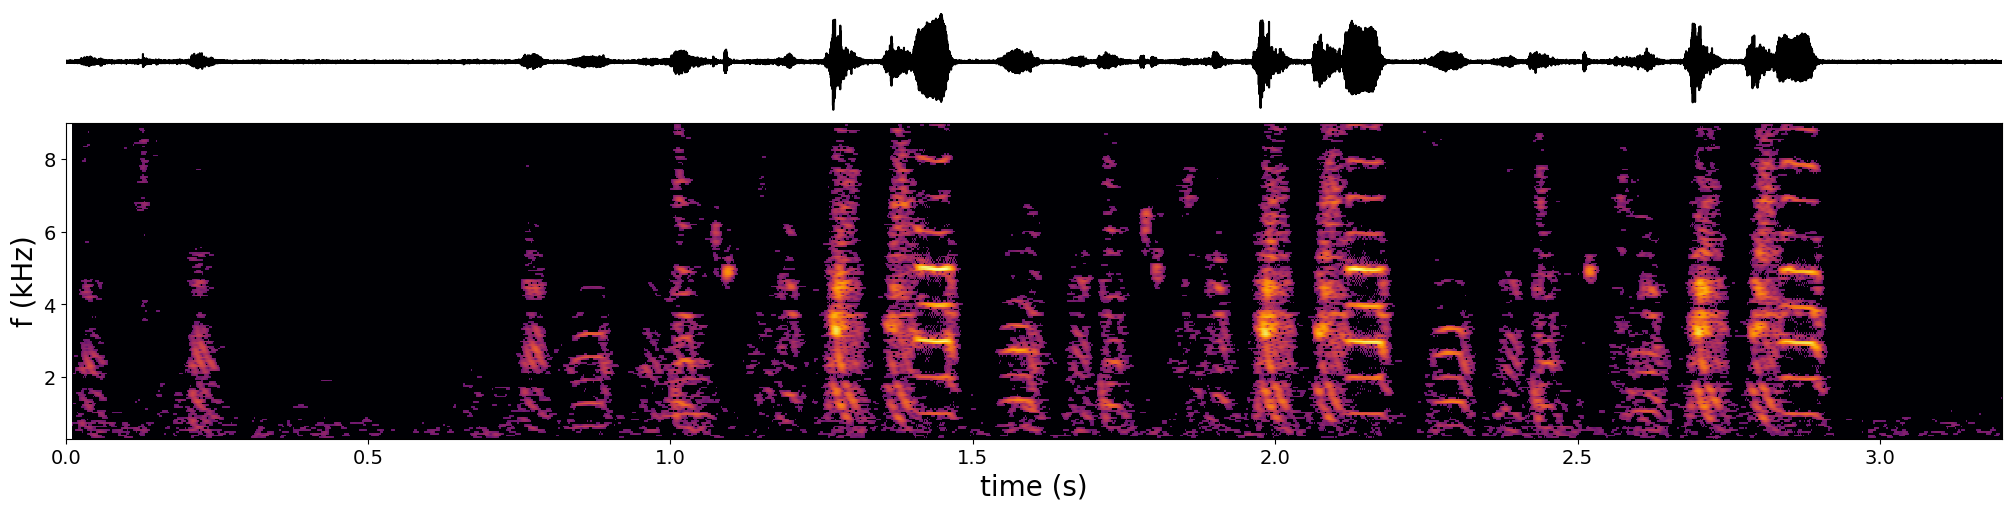

In [34]:
fig, ax = plt.subplots(nrows=2, gridspec_kw={'height_ratios': [1,3]}, figsize=(20, 5), constrained_layout=True)
ref_id = 0
ps(bout_df.iloc[bout_idx]['waveform'].flatten(), fs, fig, ax)

### Run the following three blocks for a few example bouts
Examine directed and undirected sessions

longest silence 0.992
longest vocalization 0.1499999999999999


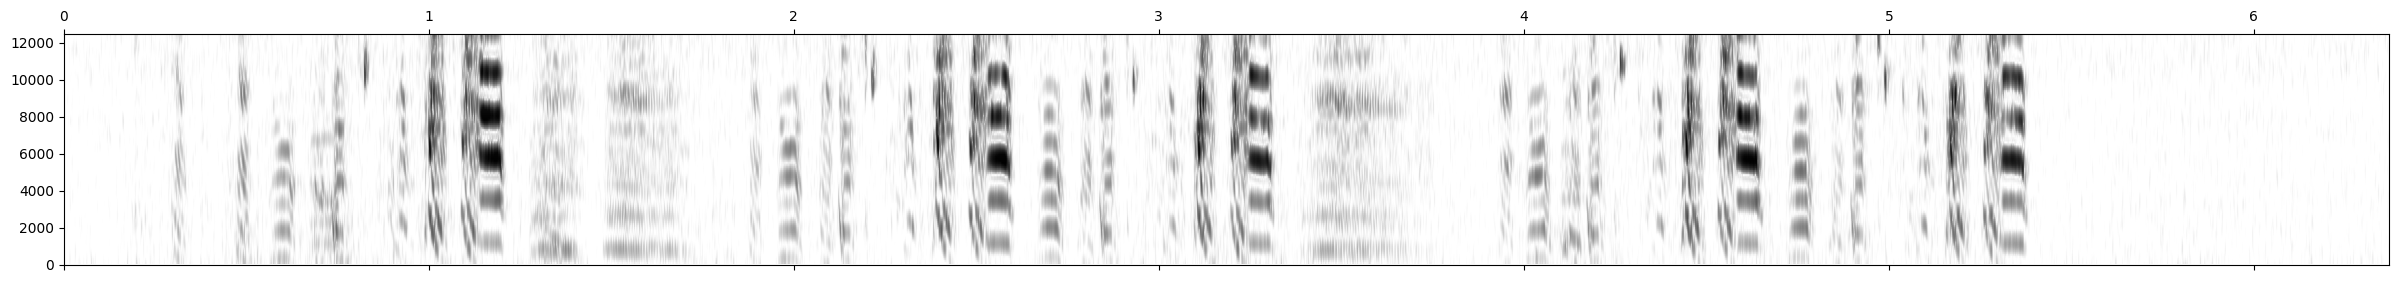

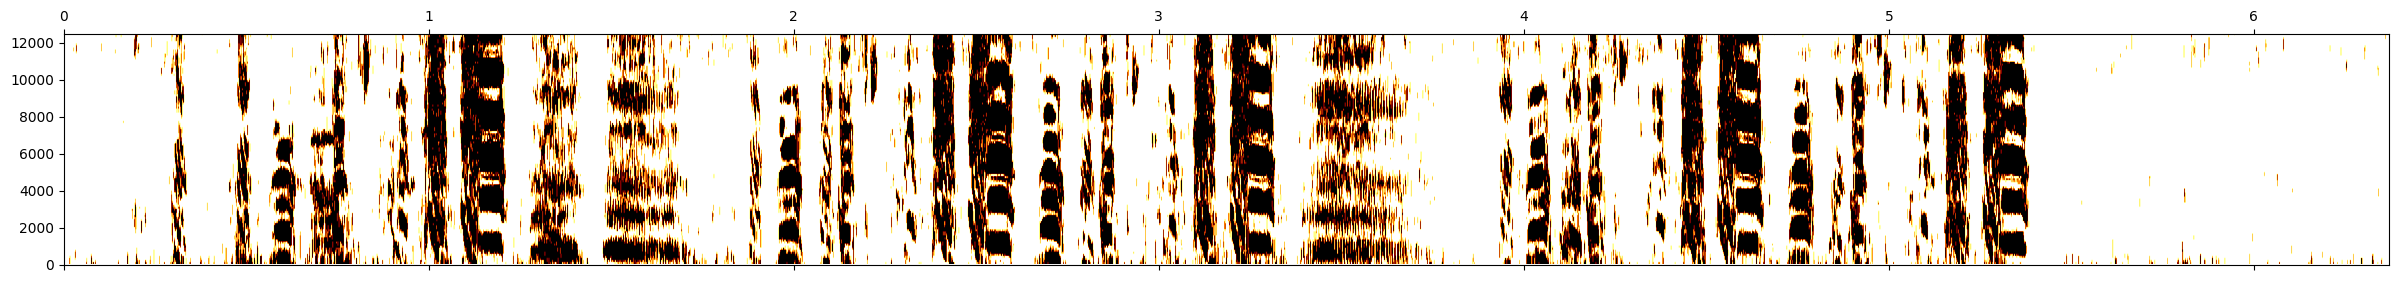

continutity filter size: (41, 5)


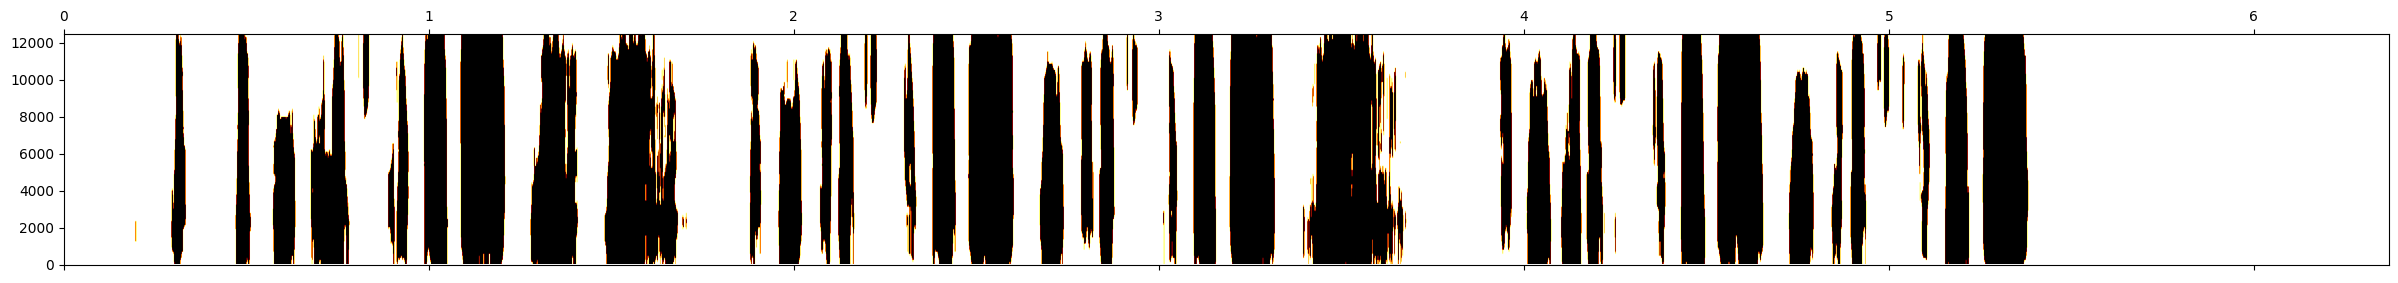

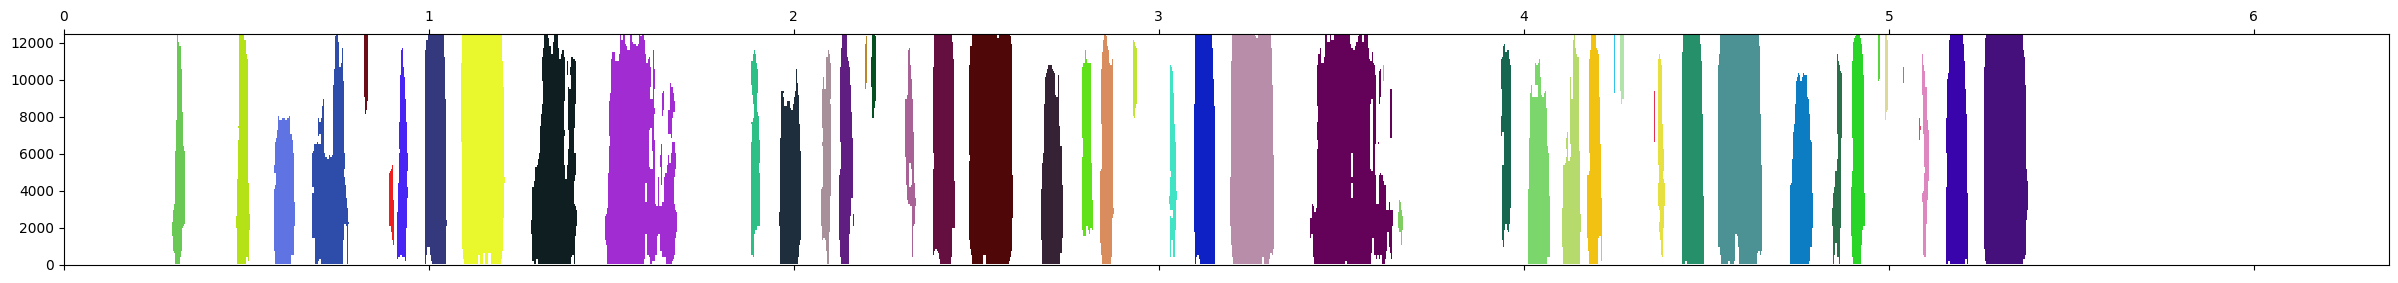

element coverage:   0%|          | 0/80 [00:00<?, ?it/s]

element length:   0%|          | 0/80 [00:00<?, ?it/s]

unique elements: 80


merging temporal neighbors:   0%|          | 0/80 [00:00<?, ?it/s]

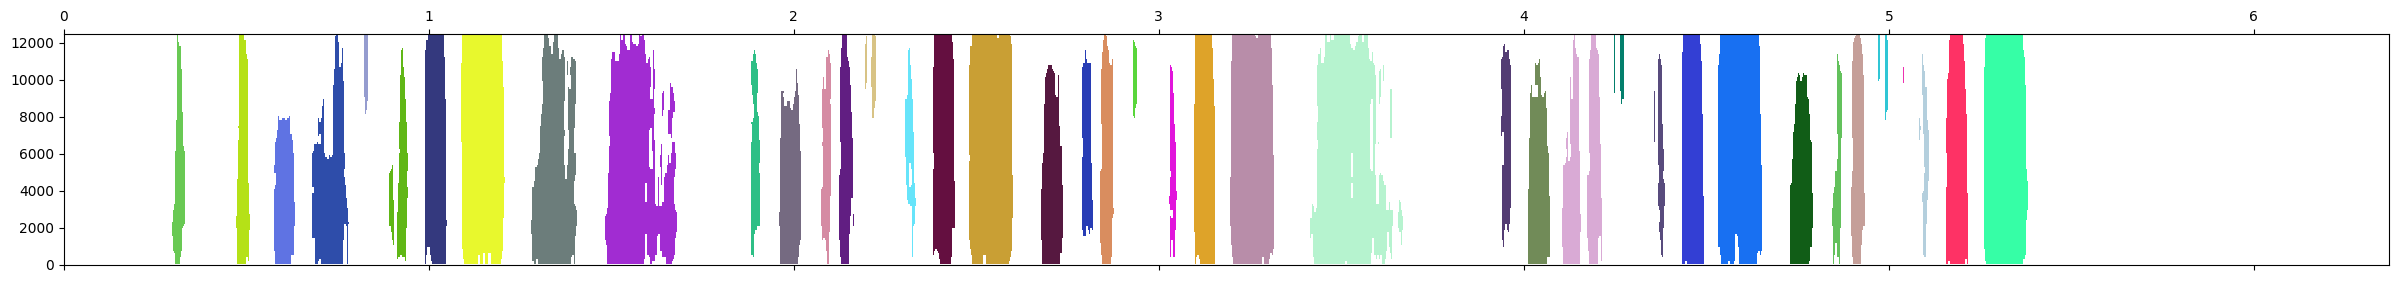

unique elements: 42
min element size: 205


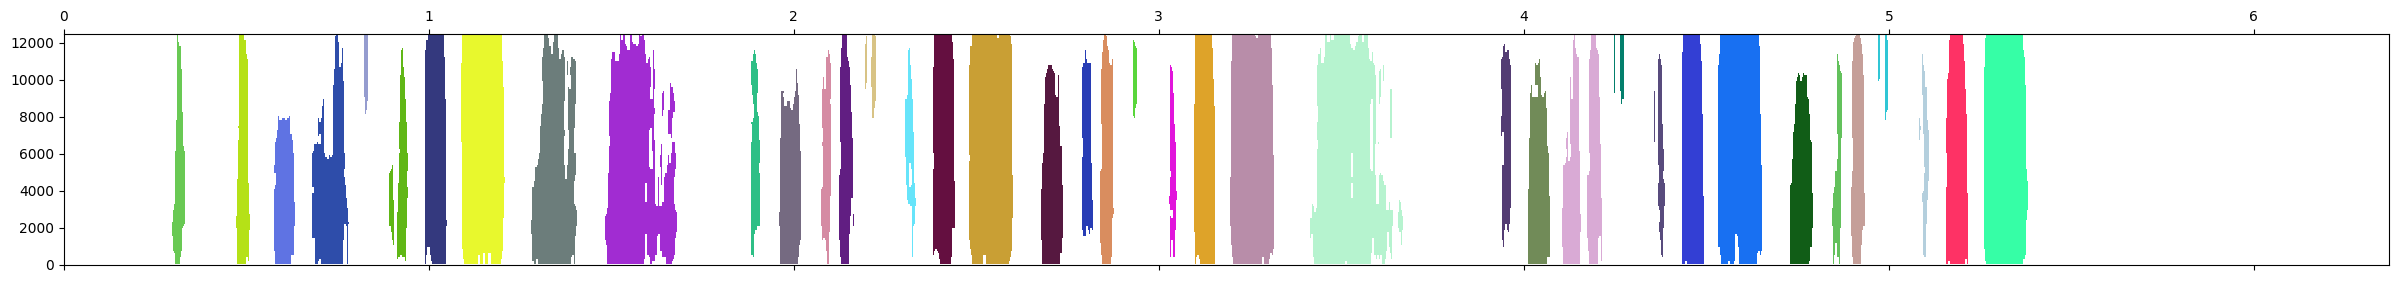

unique elements: 40


In [59]:
bout_idx = 2
x = bout_df.iloc[bout_idx]['waveform'].flatten()
x = x.astype(float)/np.max(np.abs(x))
results = segment_bout(x, fs)

  0%|          | 0/40 [00:00<?, ?it/s]

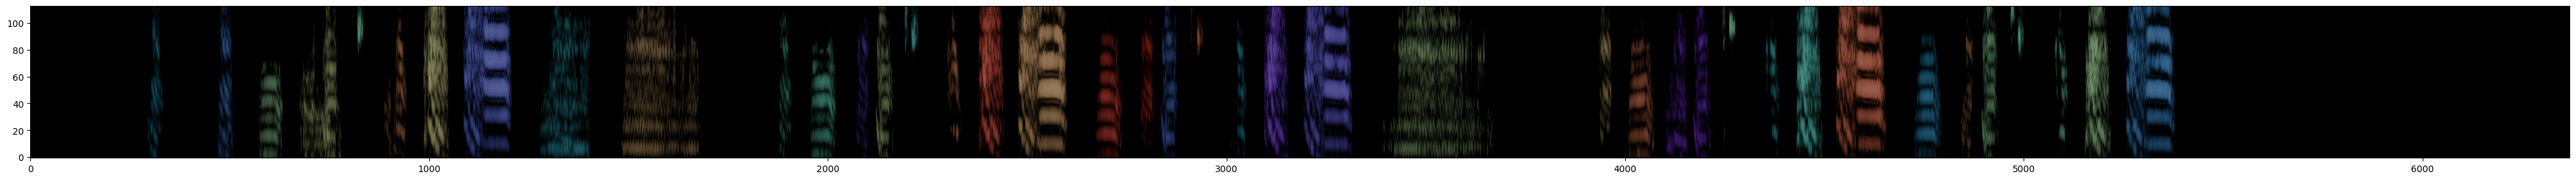

In [60]:
labelled_spec = plot_labelled_elements(results['elements'], results['spec'], background='black', figsize=(50,3)); 

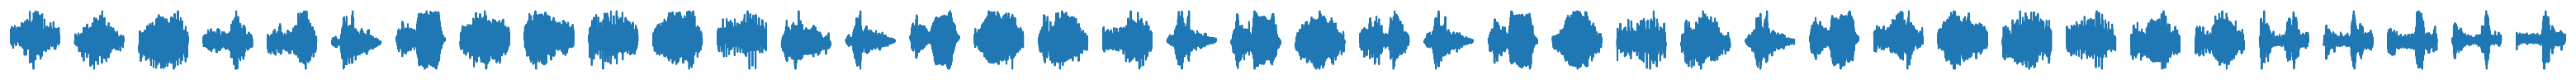

In [61]:
fig, axs = plt.subplots(ncols=len(results['onsets']), figsize= (len(results['onsets']),1))
for axi, (onset, offset) in enumerate(zip(results['onsets'], results['offsets'])):
    axs[axi].plot(x[int(onset*fs):int(offset*fs)])
    axs[axi].axis('off')

#### Option to listen to a bout

In [14]:
ipd.Audio(x,rate=fs)

## When satisfied with parameters, run for full session

In [62]:
# create bouts_segmented dataframe
bouts_segmented = bout_df.copy()
bouts_segmented['on_ms'] = None
bouts_segmented['off_ms'] = None
bouts_segmented['on_sample'] = None
bouts_segmented['off_sample'] = None

print(f"Bird {sess_par['bird']}, sess {sess_par['sess']}: {len(bouts_segmented)} bouts need to be segmented...")

empty_waveforms = []
for bout_idx in bouts_segmented.index.to_list():
    
    # segment bouts
    x = bout_df.loc[bout_idx]['waveform'].flatten()
    if x.size==0:
        print(f"- bout_idx {bout_idx}: empty waveform, skipping...")
        empty_waveforms.append(bout_idx)
        continue
    x = x.astype(float)/np.max(np.abs(x))
    results = segment_bout(x, fs, verbose=False)
    
    # update bouts_segmented
    bouts_segmented.at[bout_idx, 'on_ms'] = (np.array(results['onsets']) * 1000).astype(int)
    bouts_segmented.at[bout_idx, 'off_ms'] = (np.array(results['offsets']) * 1000).astype(int)
    bouts_segmented.at[bout_idx, 'on_sample'] = (np.array(results['onsets']) * bout_df.at[bout_idx, 'sample_rate']).astype(int)
    bouts_segmented.at[bout_idx, 'off_sample'] = (np.array(results['offsets']) * bout_df.at[bout_idx, 'sample_rate']).astype(int)
    
# drop rows with empty waveforms
bouts_segmented = bouts_segmented.drop(index=empty_waveforms)

# save segmentation parameters
with open(os.path.join(epoch_struct['folders']['derived'],'seg_params.pickle'), 'wb') as f:
    pickle.dump(seg_params, f)

print(' ...done!')

Bird z_r12r13_21, sess 2021-06-27: 12 bouts need to be segmented...
 ...done!


## Process segmented bouts

### Bandpass filter

In [63]:
# bouts_segmented['waveform'] = bouts_segmented.apply(lambda r: nr.reduce_noise(r['waveform'], r['sample_rate']), axis=1)
bouts_segmented['bout_waveform_filt'] = bouts_segmented.apply(lambda r: butter_bandpass_filter(r['waveform'], 300, 12000, r['sample_rate']), axis=1)
bouts_segmented.rename(columns={'waveform': 'bout_waveform_raw'}, inplace=True)

### Make separated syllables

In [64]:
# Create a dataframe for segmented syllables
dfs = []
for index, row in bouts_segmented.iterrows():
    file = row['file']
    sess = row['sess']
    epoch = row['epoch']
    sample_rate = row['sample_rate']
    bout_index = index
    bout_waveform_raw = row['bout_waveform_raw']
    bout_waveform_filt = row['bout_waveform_filt']
    start_ms_ap_0_bout = row['start_ms_ap_0']
    start_sample_ap_0_bout = row['start_sample_ap_0']
    on_samples = row['on_sample']
    off_samples = row['off_sample']
    on_mss = row['on_ms']
    off_mss = row['off_ms']
    
    data = []
    for syllable_index, (on_sample, 
                         off_sample, 
                         on_ms, 
                         off_ms) in enumerate( zip(on_samples, 
                                                   off_samples, 
                                                   on_mss, 
                                                   off_mss)
                                             ):
        # get start_ms_ap_0
        start_ms_ap_0 = int(start_ms_ap_0_bout + on_ms)
        
        # get start_sample_ap_0
        start_sample_ap_0 = int(start_sample_ap_0_bout + on_sample/fs*ap_fs)
        
        data.append({
            'file': file,
            'sess': sess,
            'epoch': epoch,
            'sample_rate': sample_rate,
            'bout_index': bout_index,
            'bout_waveform_raw': bout_waveform_raw,
            'bout_waveform_filt': bout_waveform_filt,
            'start_ms_ap_0': start_ms_ap_0,
            'start_sample_ap_0': start_sample_ap_0,
            'syllable_index': syllable_index,
            'on_sample': on_sample,
            'off_sample': off_sample,
            'on_ms': on_ms,
            'off_ms': off_ms,
            'syllable_waveform': bout_waveform_filt[on_sample:off_sample]})
    
    df = pd.DataFrame(data)
    dfs.append(df)

syl_df = pd.concat(dfs, ignore_index=True)

In [65]:
# remove empty syllables (product of errors in segmentation)
empty_rows = []
for i, arr in enumerate(syl_df.syllable_waveform.values):
    if len(arr) == 0: empty_rows.append(i)
if empty_rows:
    print('Bouts with empty syllables:', syl_df.iloc[empty_rows]['bout_index'].unique())

syl_df = syl_df[syl_df['syllable_waveform'].apply(lambda x: len(x) != 0)]

In [66]:
# normalize audio
syl_df['syllable_waveform'] = [syll/max(np.min(syll), np.max(syll), key=abs) for i, syll in enumerate(syl_df['syllable_waveform'].values)]
syl_df['syllable_waveform'] = [np.nan_to_num(syll) if not np.all(np.isfinite(syll)) else syll for syll in syl_df['syllable_waveform'].values]

  0%|          | 0/100 [00:00<?, ?it/s]

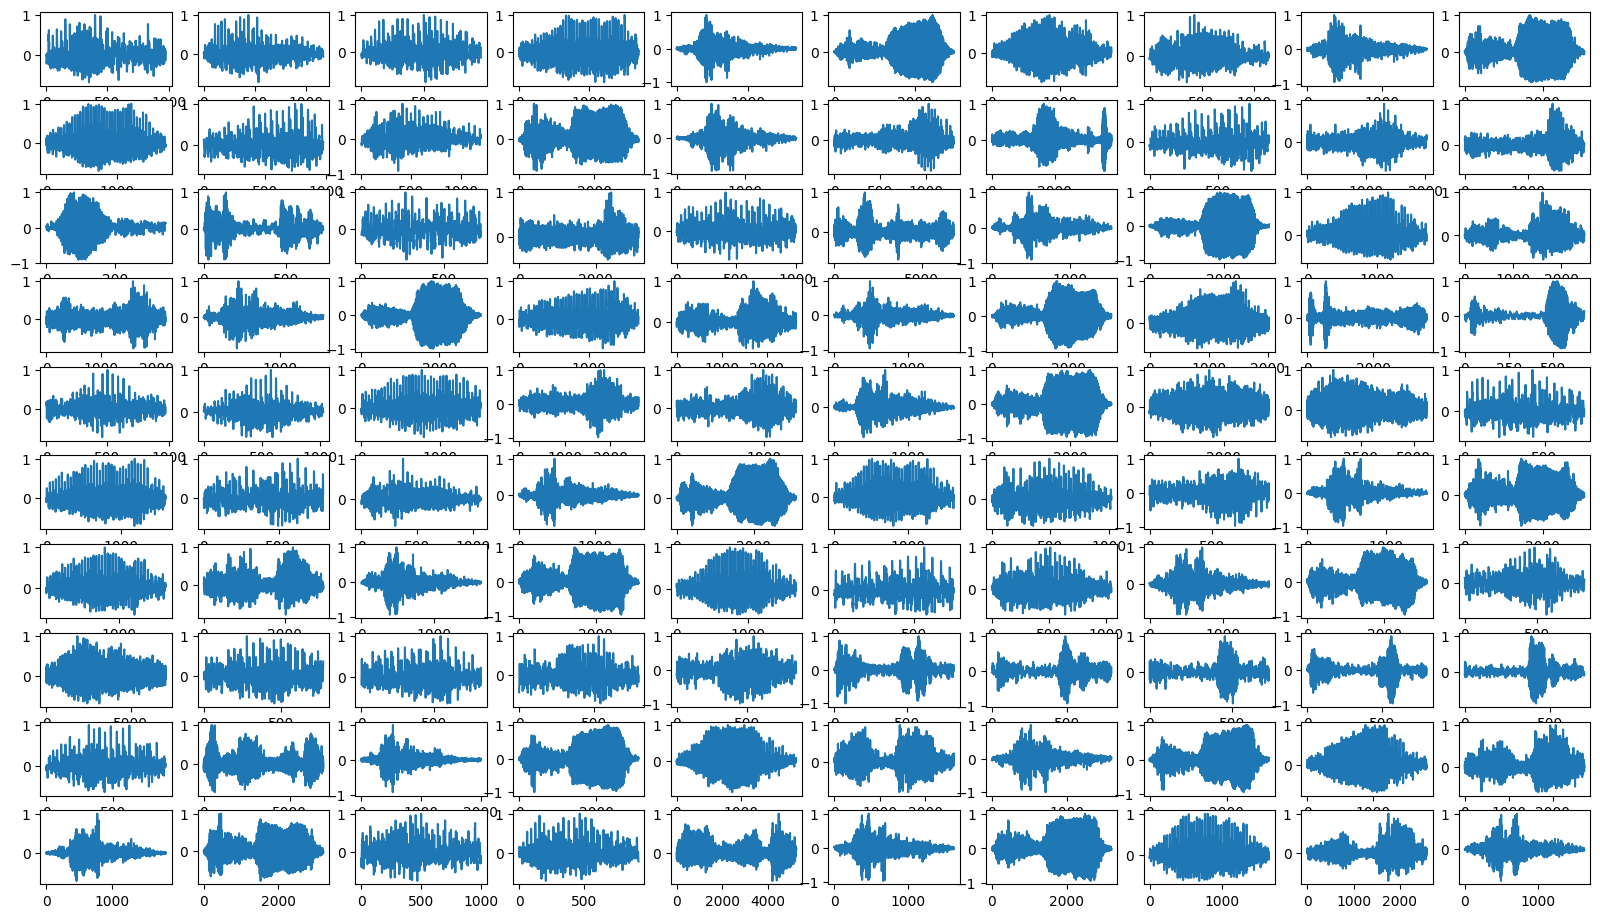

In [67]:
# Plot some of the syllables to see how they look
nrows = 10
ncols = 10
zoom = 2
fig, axs = plt.subplots(ncols=ncols, nrows = nrows, figsize = (ncols*zoom, nrows+zoom/1.5))
for i, syll in tqdm(enumerate(syl_df['syllable_waveform'].values), total = nrows*ncols):
    ax = axs.flatten()[i]
    ax.plot(syll)
    if i == nrows*ncols-1:
        break

### Perform UMAP and clustering

In [68]:
syllables_wav = syl_df.syllable_waveform.values
syllables_rate = syl_df.sample_rate.values

In [69]:
hparams = HParams(
    num_mel_bins = 64,
    mel_lower_edge_hertz=300,
    mel_upper_edge_hertz=12000,
    butter_lowcut = 300,
    butter_highcut = 12000,
    ref_level_db = 20,
    min_level_db = -100,
    mask_spec = True,
    win_length_ms = 4,
    hop_length_ms = 1,
    nex = -1,
    n_jobs = -1,
    verbosity = 0,
)

In [70]:
n_jobs = 36
verbosity = 0

In [71]:
# create spectrograms
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllables_spec = parallel(
        delayed(make_spec)(
            syllable,
            rate,
            hparams=hparams,
            mel_matrix=prepare_mel_matrix(hparams, rate),
            use_mel=True,
            use_tensorflow=False,
        )
        for syllable, rate in tqdm(
            zip(syllables_wav, syllables_rate),
            total=len(syllables_rate),
            desc="getting syllable spectrograms",
            leave=False,
        )
    )

getting syllable spectrograms:   0%|          | 0/338 [00:00<?, ?it/s]

2024-10-31 16:06:47.753177: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-10-31 16:06:47.754349: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: pakhi.ucsd.edu
2024-10-31 16:06:47.754356: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: pakhi.ucsd.edu
2024-10-31 16:06:47.755246: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 520.61.5
2024-10-31 16:06:47.755265: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 520.61.5
2024-10-31 16:06:47.755269: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 520.61.5


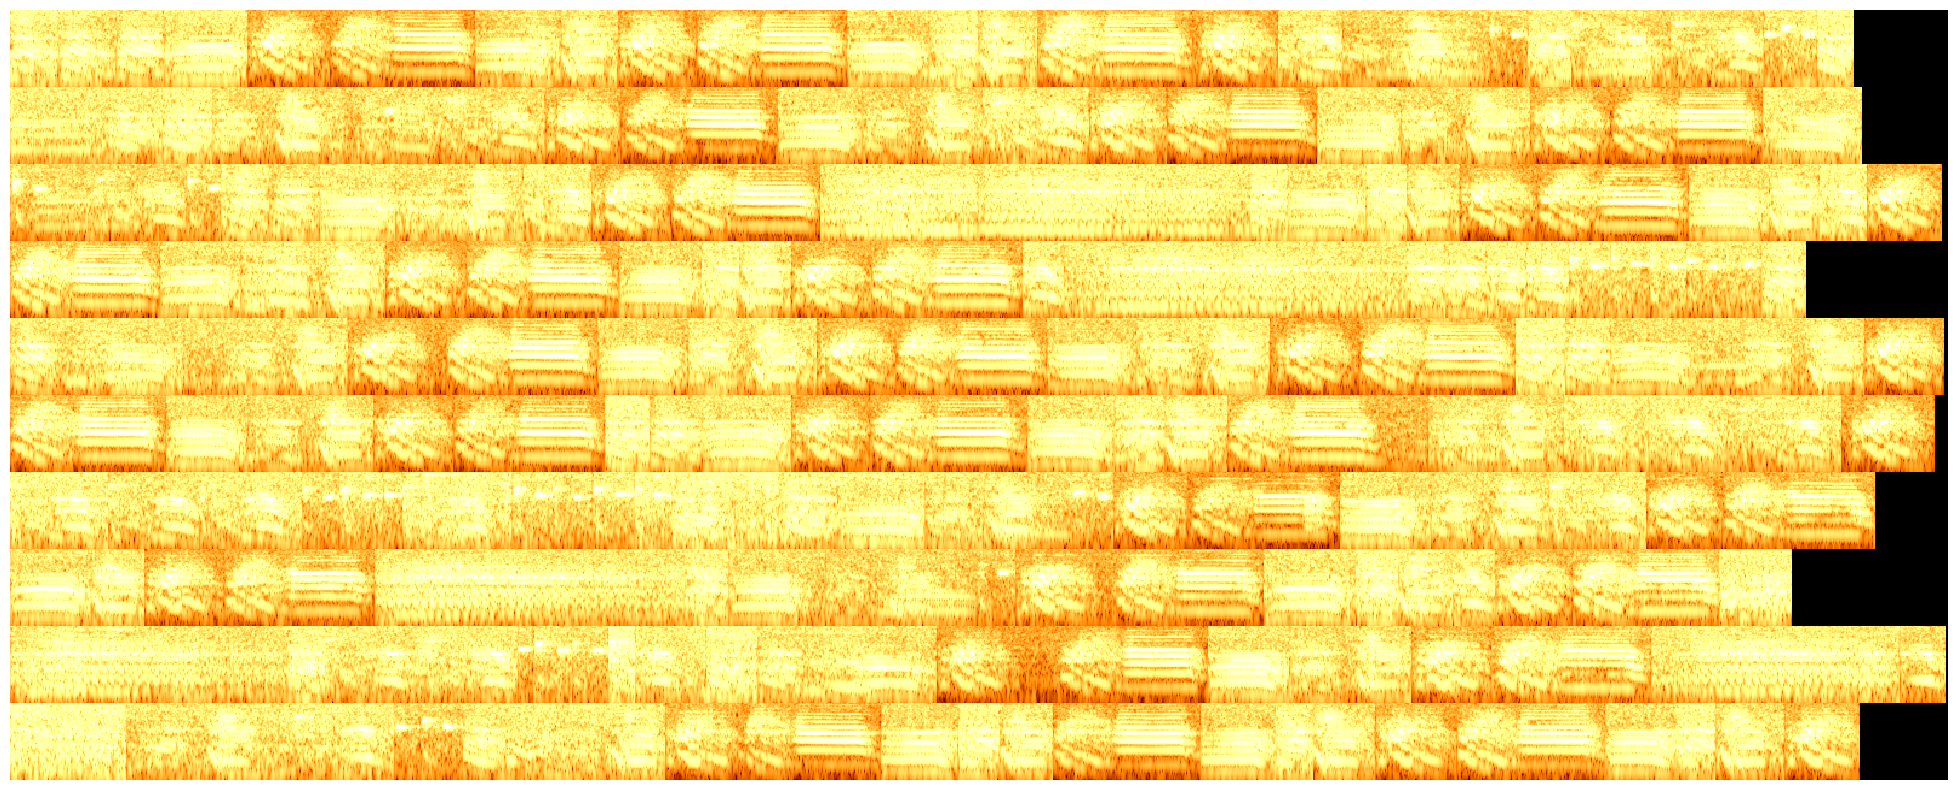

In [72]:
draw_spec_set(syllables_spec, zoom=1, maxrows=10, colsize=40)

In [73]:
# log rescale spectrograms
log_scaling_factor = 4

with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllables_spec = parallel(
        delayed(log_resize_spec)(spec, scaling_factor=log_scaling_factor)
        for spec in tqdm(syllables_spec, desc="scaling spectrograms", leave=False)
    )

scaling spectrograms:   0%|          | 0/338 [00:00<?, ?it/s]

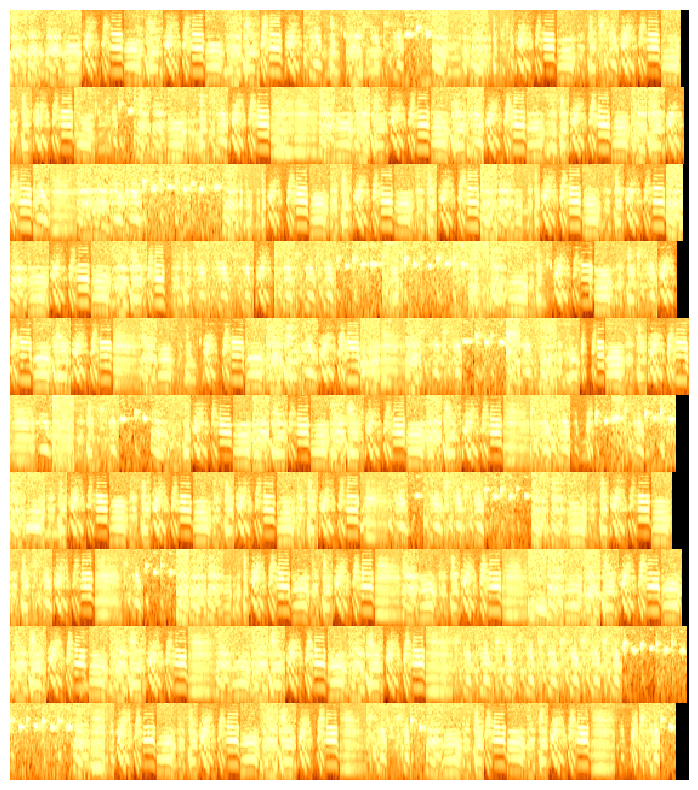

In [74]:
draw_spec_set(syllables_spec, zoom=1, maxrows=10, colsize=40)

In [75]:
syl_df['spec'] = syllables_spec
syl_df.head(2)

file        sess    epoch  \
0  /mnt/cube/chronic_ephys/der/z_r12r13_21/2021-0...  2021-06-27  0727_g0   
1  /mnt/cube/chronic_ephys/der/z_r12r13_21/2021-0...  2021-06-27  0727_g0   

   sample_rate  bout_index                                  bout_waveform_raw  \
0        25000           0  [-8.47208487397752, -58.80909223561056, -6.854...   
1        25000           0  [-8.47208487397752, -58.80909223561056, -6.854...   

                                  bout_waveform_filt  start_ms_ap_0  \
0  [-6.9266275062171685, -48.777581446513466, -7....        1449137   
1  [-6.9266275062171685, -48.777581446513466, -7....        1449317   

   start_sample_ap_0  syllable_index  on_sample  off_sample  on_ms  off_ms  \
0           43474071               0        625        1600     25      64   
1           43479471               1       5125        6300    205     252   

                                   syllable_waveform  \
0  [-0.003897989377363217, 0.010960224434566297, ...   
1  [0.027319941694774086, -0.013291945579137258, ...   

                                                spec  
0  [[0.6349124, 0.6060125, 0.60642517, 0.5566368,...  
1  [[0.6001154, 0.6367577, 0.62517536, 0.66152596...

#### Pad spectrograms

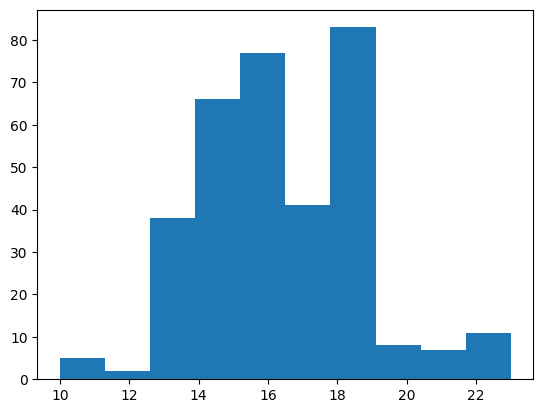

In [76]:
# plot length of syllables
syll_lens = [np.shape(i)[1] for i in syl_df['spec']]
plt.hist(syll_lens);

In [77]:
# normalize spectrograms
def norm(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

# convert to uint8 to save space
specs = list(syl_df.spec.values)
syllables_spec = [(norm(syll)*255).astype('uint8') for syll in specs]
# syllables_spec = [np.nan_to_num(syll) for syll in specs]

# pad spectrogram
all_syl_len = [s.shape[-1] for s in syllables_spec]
pad_len = np.max(all_syl_len)
syl_df['processed_spec'] = [pad_spectrogram(spec, pad_len) for spec in syllables_spec]
print('All syllables padded to',pad_len)

All syllables padded to 23


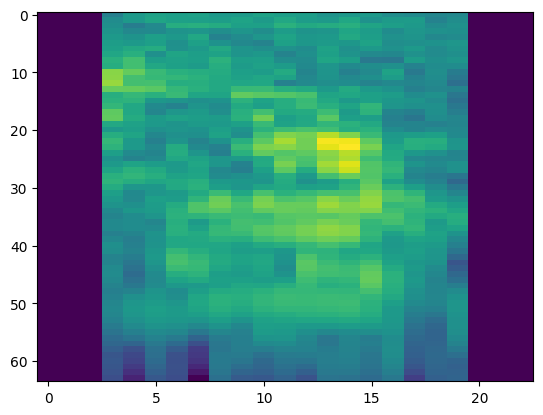

In [78]:
# plot padded syllable
plt.imshow(syl_df.iloc[18]['processed_spec'][::-1], aspect='auto')

#### Embed and cluster spectrograms

In [79]:
# Cluster spectrograms using UMAP
specs = list(syl_df.processed_spec.values)

# flatten the spectrograms into 1D
specs_flattened = flatten_spectrograms(specs)

# fit UMAP
fit = umap.UMAP(min_dist = 0.2, n_neighbors = 20, verbose = True)
z = list(fit.fit_transform(specs_flattened))
syl_df['umap'] = z
z = np.vstack(z)

UMAP(min_dist=0.2, n_neighbors=20, verbose=True)
Thu Oct 31 16:07:02 2024 Construct fuzzy simplicial set
Thu Oct 31 16:07:02 2024 Finding Nearest Neighbors
Thu Oct 31 16:07:04 2024 Finished Nearest Neighbor Search
Thu Oct 31 16:07:07 2024 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Thu Oct 31 16:07:14 2024 Finished embedding


In [86]:
# label clusters using KMeans
kmeans = KMeans(n_clusters=9, random_state=42, n_init=10)
kmeans_clusters = kmeans.fit_predict(z)
syl_df['kmeans_labels'] = kmeans_clusters

In [91]:
# label clusters using HDBSCAN
min_cluster_size = int(len(z) * 0.001)
min_cluster_size = 10
print(f"min cluster size: {min_cluster_size} (adjust if needed)")
clusterer = hdbscan.HDBSCAN(
    min_cluster_size = min_cluster_size
).fit(z)

# write into expected format for scatter_spec
hdbscan_clusters = np.empty_like(kmeans_clusters)
hdbscan_clusters[:] = clusterer.labels_
hdbscan_clusters -= np.min(hdbscan_clusters)
syl_df['hdbscan_labels'] = hdbscan_clusters

min cluster size: 10 (adjust if needed)


[HDBSCAN](https://joss.theoj.org/papers/10.21105/joss.00205) is a hierarchical density-based clustering algorithm applied to UMAP projections of spectrograms

Here's a graphic explanation from Tim Sainburg's [AVGN paper](https://doi.org/10.1371/journal.pcbi.1008228):

![](https://journals.plos.org/ploscompbiol/article/figure/image?size=large&id=10.1371/journal.pcbi.1008228.g009)

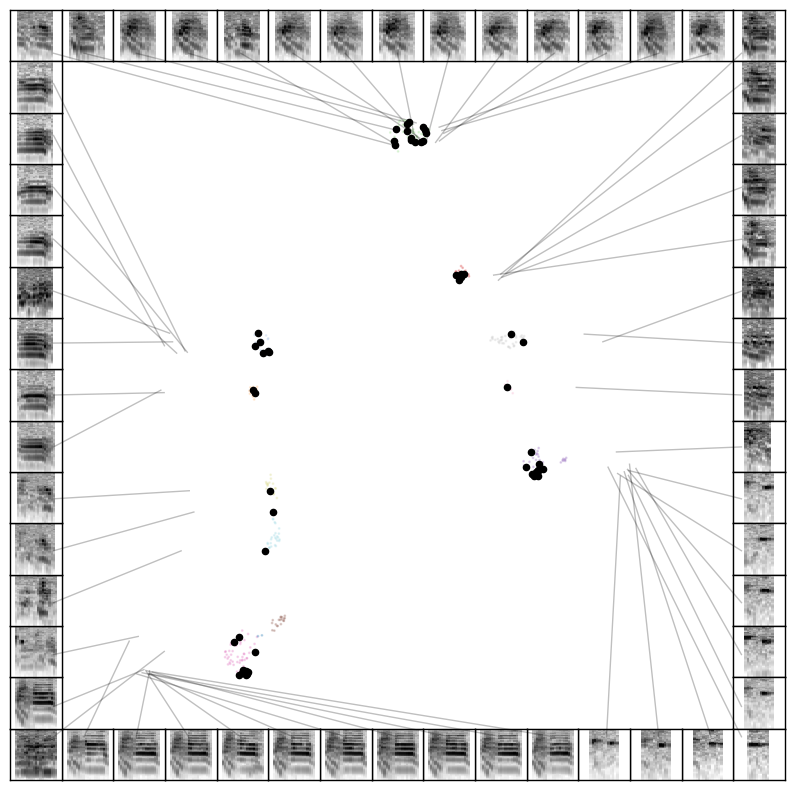

In [92]:
# display labeled clusters
scatter_spec(
        np.vstack(z),
        specs,
        column_size=15,
        #x_range = [-5.5,7],
        #y_range = [-10,10],
        pal_color="hls",
        color_points=False,
        enlarge_points=20,
        figsize=(10, 10),
        scatter_kwargs = {
            'labels': hdbscan_clusters,
            'alpha':0.25,
            's': 1,
            'show_legend': False
        },
        matshow_kwargs = {
            'cmap': plt.cm.Greys
        },
        line_kwargs = {
            'lw':1,
            'ls':"solid",
            'alpha':0.25,
        },
        draw_lines=True
    );
plt.show()

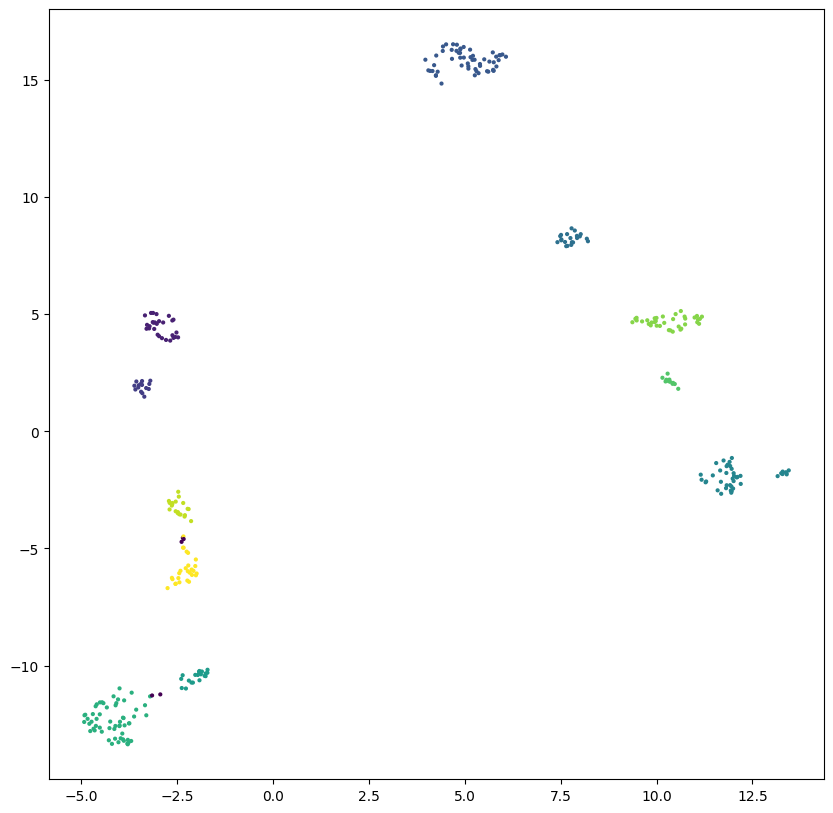

/mnt/cube/lo/envs/birdsong/lib/python3.8/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=851
  warnings.warn(
/mnt/cube/lo/envs/birdsong/lib/python3.8/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=775
  warnings.warn(
/mnt/cube/lo/envs/birdsong/lib/python3.8/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=850
  warnings.warn(
/mnt/cube/lo/envs/birdsong/lib/python3.8/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=674
  warnings.warn(
/mnt/cube/lo/envs/birdsong/lib/python3.8/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=1000
  warnings.warn(
/mnt/cube/lo/envs/birdsong/lib/python3.8/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=

In [93]:
plt.figure(figsize=(10,10))
plt.scatter(z[:, 0], z[:, 1], c=hdbscan_clusters, cmap='viridis', s=4)

In [94]:
syl_df['label_orig'] = hdbscan_clusters

### Remove small clusters
(Result of noise or faulty segmentations)

In [72]:
unique, counts = np.unique(kmeans_clusters, return_counts=True)
print(len(unique),'clusters:',counts, 'counts')

22 clusters: [1442 4421 9977 7389 2315  477 2981 1475 5156 8142  620 2026 8985  375
 2078 4691  288  291  220  293  209  391] counts


In [67]:
large_clusters = unique[counts >= 160]
filtered_embeddings = z[np.isin(kmeans_clusters, large_clusters)]
filtered_labels = kmeans_clusters[np.isin(kmeans_clusters, large_clusters)]

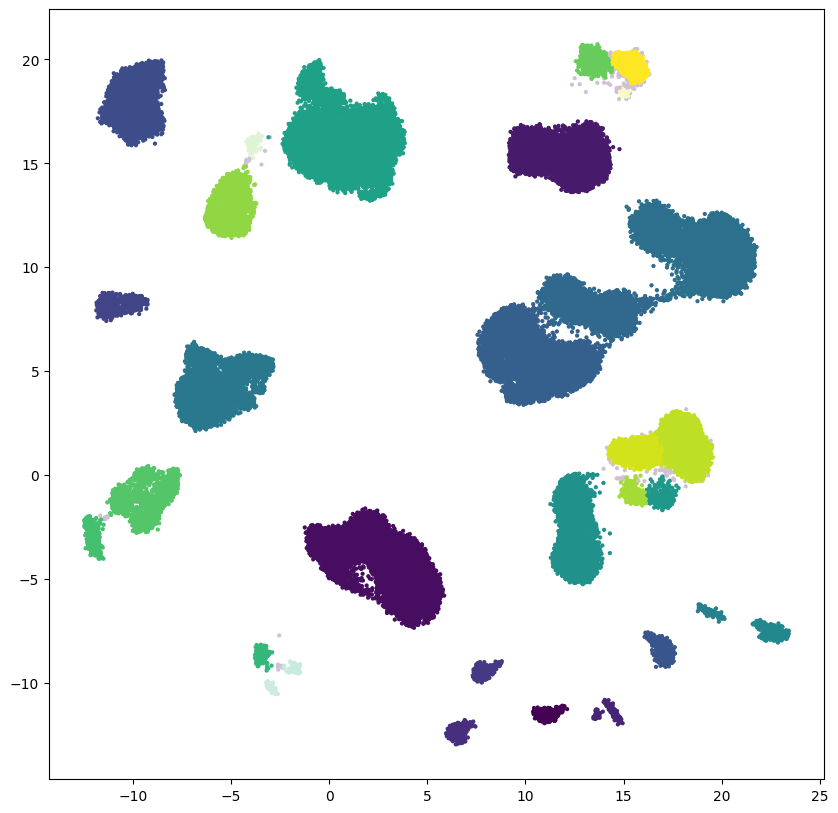

In [68]:
def lighten_color(color, amount=0.25):
    """
    Lightens the given color by blending it with white
    :param color: Color in RGB format
    :param amount: Blend amount (0.0 - 1.0)
    :return: Lightened color in RGB format
    """
    return tuple(np.append(np.array([1,1,1])*(1-amount) + np.array(color[:3])*amount, color[3]))

plt.figure(figsize=(10,10))
plt.scatter(z[:, 0], z[:, 1], c=[lighten_color(c) for c in 
                                 plt.cm.viridis((kmeans_clusters-np.min(kmeans_clusters))/(np.max(kmeans_clusters)-np.min(kmeans_clusters)))], s=4);
plt.scatter(filtered_embeddings[:, 0], filtered_embeddings[:, 1], c=filtered_labels, cmap='viridis', s=4);

## Filter out noise syllables and UMAP again??

In [76]:
# fit new UMAP
filtered_specs = specs_flattened[np.isin(kmeans_clusters, large_clusters)]
fit2 = umap.UMAP(min_dist = 0.1, n_neighbors = 500, verbose = True)
z2 = list(fit2.fit_transform(filtered_specs))
z2 = np.vstack(z2)

UMAP(n_neighbors=500, verbose=True)
Wed Jul 31 19:43:34 2024 Construct fuzzy simplicial set
Wed Jul 31 19:43:34 2024 Finding Nearest Neighbors
Wed Jul 31 19:43:34 2024 Building RP forest with 11 trees
Wed Jul 31 19:43:35 2024 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Wed Jul 31 19:44:33 2024 Finished Nearest Neighbor Search
Wed Jul 31 19:44:38 2024 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Wed Jul 31 19:45:29 2024 Finished embedding


In [77]:
# label clusters using KMeans
kmeans2 = KMeans(n_clusters=7, random_state=42, n_init=10)
kmeans_clusters2 = kmeans2.fit_predict(z2)

In [82]:
# label clusters using HDBSCAN
min_cluster_size2 = int(len(z2) * 0.001)
min_cluster_size2 = 50
print(f"min cluster size: {min_cluster_size2} (adjust if needed)")
clusterer2 = hdbscan.HDBSCAN(
    min_cluster_size = min_cluster_size2
).fit(z2)

# write into expected format for scatter_spec
hdbscan_clusters2 = np.empty_like(kmeans_clusters2)
hdbscan_clusters2[:] = clusterer2.labels_
hdbscan_clusters2 -= np.min(hdbscan_clusters2)

min cluster size: 50 (adjust if needed)


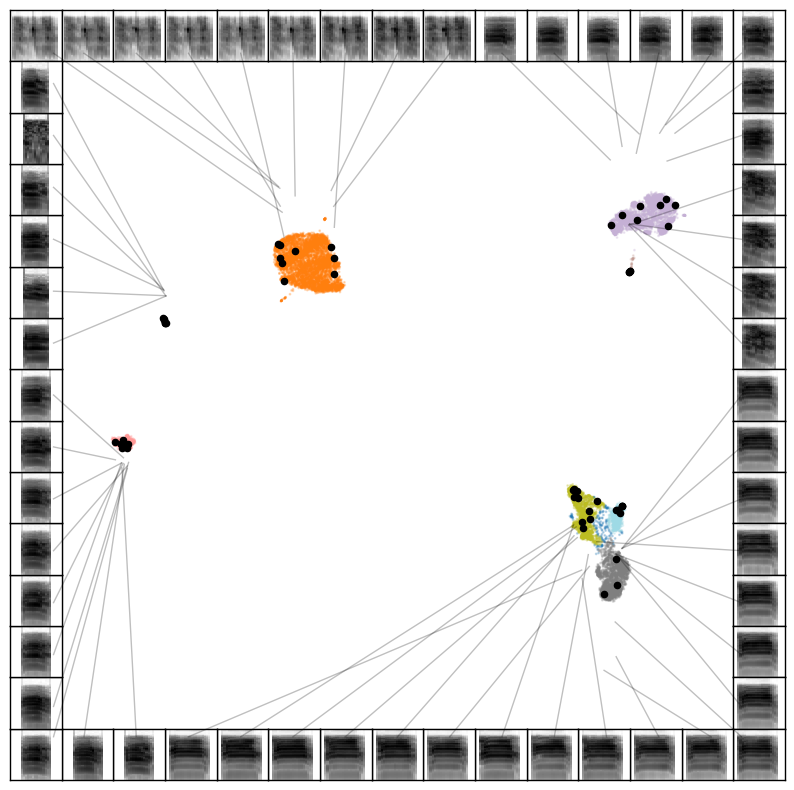

In [83]:
# display labeled clusters
scatter_spec(
        np.vstack(z2),
        np.array(specs)[np.isin(kmeans_clusters, large_clusters)],
        column_size=15,
        #x_range = [-5.5,7],
        #y_range = [-10,10],
        pal_color="hls",
        color_points=False,
        enlarge_points=20,
        figsize=(10, 10),
        scatter_kwargs = {
            'labels': kmeans_clusters2,
            'alpha':0.25,
            's': 1,
            'show_legend': False
        },
        matshow_kwargs = {
            'cmap': plt.cm.Greys
        },
        line_kwargs = {
            'lw':1,
            'ls':"solid",
            'alpha':0.25,
        },
        draw_lines=True
    );
plt.show()

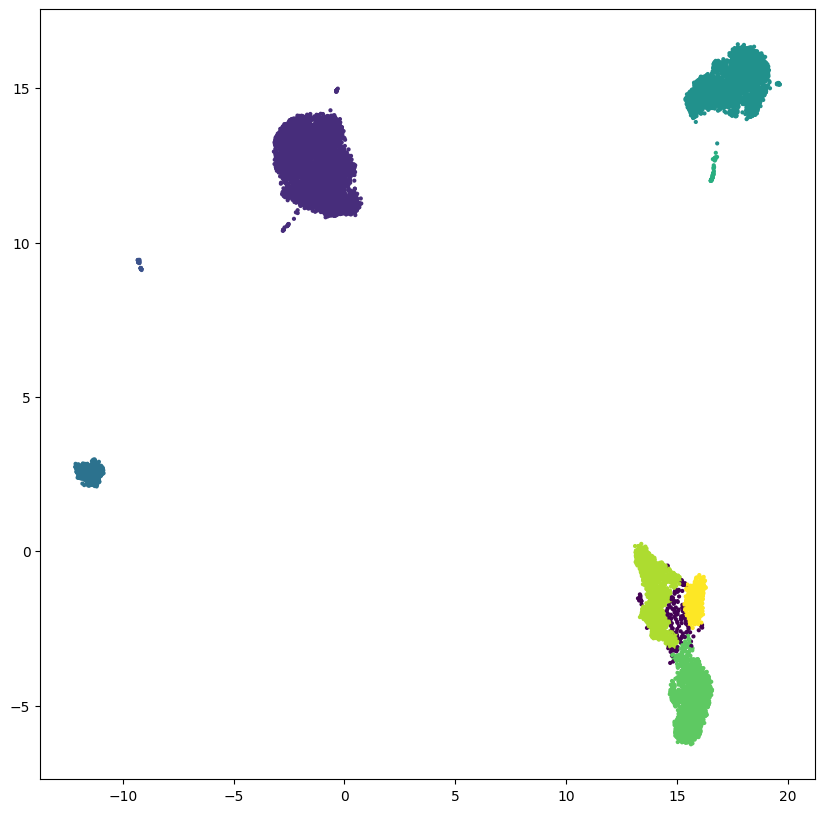

In [84]:
plt.figure(figsize=(10,10))
plt.scatter(z2[:, 0], z2[:, 1], c=kmeans_clusters2, cmap='viridis', s=4);

In [85]:
unique, counts = np.unique(kmeans_clusters2, return_counts=True)
print(len(unique),'clusters:',counts, 'counts')

9 clusters: [ 160 5650   91  856 3887   83 2418 2045  877] counts


## Store new labels

In [52]:
is_labeled = np.isin(kmeans_clusters, large_clusters)
labels_filtered = np.full_like(is_labeled, np.nan, dtype=float)
umap_filtered = np.full((is_labeled.shape[0], 2), np.nan, dtype=float)
labels_filtered[is_labeled] = kmeans_clusters2
umap_filtered[is_labeled] = z2

In [64]:
syl_df['labels_filtered'] = pd.Series(labels_filtered).astype('Int64')
syl_df['umap_filtered'] = umap_filtered.tolist()

### Option to manually transform mappings if needed

/mnt/cube/lo/envs/plot_sonogram.py:47: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[1].pcolormesh(t, f, np.log(sxx), cmap='inferno')


4, 4, 4, 4, 4, 4, 0, 4, 0, 4, 1, 3, 2, 1, 0, 5, 1, 3, 2, 1, 0, 5, 1, 3, 2, 1, 0, 5, 1, 3


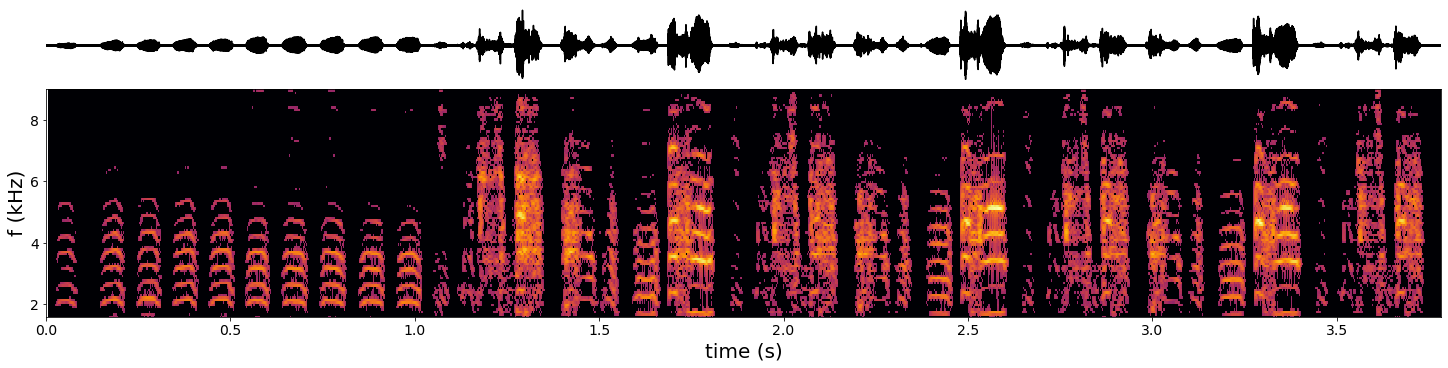

In [549]:
ref_id = 9
fig, ax = plt.subplots(nrows=2, gridspec_kw={'height_ratios': [1,3]}, figsize=(20, 5), constrained_layout=True)
bout_idx = syl_df[syl_df['bout_index']==ref_id].index.values[0]
ps(syl_df.loc[bout_idx,'bout_waveform_raw'].flatten(), syl_df.iloc[ref_id]['sample_rate'], fig, ax)
umap_syls = syl_df[syl_df['bout_index']==ref_id].label_orig.values
print(', '.join(map(str, umap_syls)))

In [553]:
transformation_mapping = {
    (4,0): 0,
    (1,): 1,
    (3,): 2,
    (2,): 3,
    (5,): 4
}

clusters_checked = [value for cluster in clusters for key, value in transformation_mapping.items() if cluster in key]
syl_df['label'] = clusters_checked
print('Number of syllables:',len(syl_df['label'].unique()))

Number of syllables: 5


### Plot syllable barcodes

In [95]:
def song_barcode(start_times, stop_times, labels, label_dict, label_pal_dict, resolution=0.01):
    begin = np.min(start_times)
    end = np.max(stop_times)
    trans_list = (
        np.zeros(int((end - begin) / resolution)).astype("str").astype("object")
    )
    # print(end, begin, end-begin, resolution, len(trans_list))
    for start, stop, label in zip(start_times, stop_times, labels):
        trans_list[
            int((start - begin) / resolution) : int((stop - begin) / resolution)
        ] = label_dict[label]

    color_list = [
        label_pal_dict[i] if i in label_pal_dict else [1, 1, 1] for i in trans_list
    ]
    color_list = np.expand_dims(color_list, 1)

    return trans_list, color_list


def indv_barcode(this_df, time_resolution=0.01, label="label", pal="tab20"):
    unique_labels = this_df[label].unique()
    
    # song palette
    label_pal = np.random.permutation(sns.color_palette(pal, len(unique_labels)))
    label_dict = {lab: str(int(i)).zfill(3) for i, lab in enumerate(unique_labels)}

    label_pal_dict = {
        label_dict[lab]: color for lab, color in zip(unique_labels, label_pal)
    }
    sns.palplot(list(label_pal_dict.values()))

    # get list of syllables by time
    trans_lists = []
    color_lists = []
    for key in tqdm(this_df.bout_index.unique(), leave=False):
        # dataframe of wavs
        wav_df = this_df[this_df['bout_index'] == key]
        labels = wav_df[label].values
        start_times = wav_df.on_ms.values
        stop_times = wav_df.off_ms.values
        trans_list, color_list = song_barcode(
            start_times,
            stop_times,
            labels,
            label_dict,
            label_pal_dict,
            resolution=time_resolution,
        )
        color_lists.append(color_list)
        trans_lists.append(trans_list)

    return color_lists, trans_lists, label_pal_dict, label_pal, label_dict

Syllable barcodes: [ 9  4  1  3  7  2  0 10  5  8  6 11]


  0%|          | 0/12 [00:00<?, ?it/s]

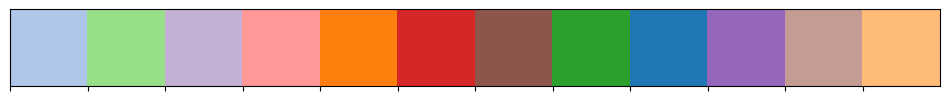

In [96]:
# Get variables for plotting
print('Syllable barcodes: ' + str(syl_df.label.unique()))

color_lists, trans_lists, label_pal_dict, label_pal, label_dict = indv_barcode(
    syl_df,
    time_resolution=12
)

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

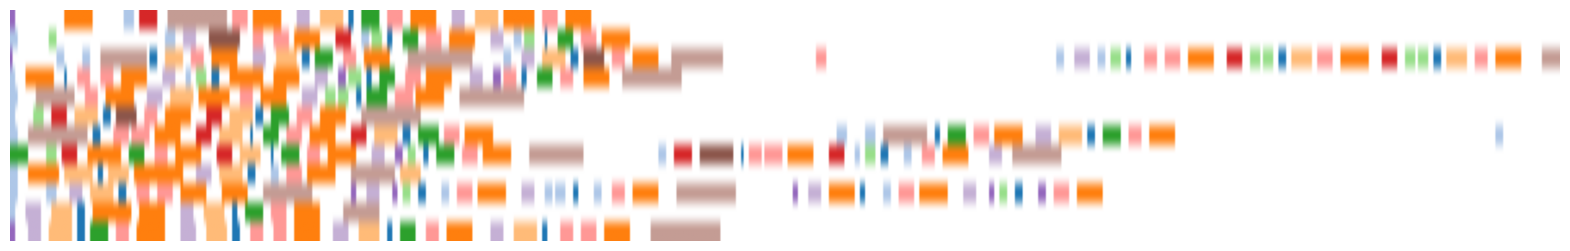

In [97]:
# Plot syllable barcodes for songs
ids = syl_df.bout_index.unique()

fig, ax = plt.subplots(figsize=(20, 3))
plot_sorted_barcodes(
    [color_lists[i] for i in ids],
    [trans_lists[i] for i in ids],
    max_list_len=600,
    seq_len=100,
    nex=200,
    figsize=(10, 4),
    ax=ax,
)
plt.show()

## Save syl_df

In [586]:
syl_df.to_pickle(os.path.join(epoch_struct['folders']['derived'],'syl_df_ap0.pickle'))